<a href="https://colab.research.google.com/github/n0trey/GUI-project/blob/master/TA%203.0-lr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [3]:
from google.colab import files
uploaded = files.upload()

Saving dimp.xlsx to dimp.xlsx


In [5]:
df_raw = pd.read_excel('dimp.xlsx',index_col=0)
df_raw.head(5)

,DATE,COGEN,SS1,SS6,WHRU,TOTAL,CHOKE_AREA_A01,CHOKE_AREA_A03,CHOKE_AREA_A04,CHOKE_AREA_A05,...,P1_SPM_A04,P1_SPM_A05,P1_SPM_A06,P1_SPM_A07,P1_SPM_A08,P1_SPM_A09,P1_SPM_A10,P1_SPM_A11,P1_SPM_A12,P1_SPM_A13
0,2019-07-23,283711,10743,0,40802,335256,0.4297,0.4076,1.0973,1.7375,...,577.079798,564.214815,548.783503,548.955087,571.889979,581.219072,609.863040,640.423480,645.529123,610.222288
1,2019-07-24,287497,10731,0,40083,338311,0.4297,0.4076,1.1080,1.6683,...,588.466113,568.621938,556.451430,562.385926,579.728583,588.914925,618.124044,652.425890,655.206040,619.232191
2,2019-07-25,285819,10755,0,40074,336648,0.4297,0.4076,1.1080,1.6683,...,575.310633,558.624740,547.115751,553.021553,573.122766,579.543288,612.541402,645.761743,650.616833,615.308352
3,2019-07-26,285435,10754,0,40202,336391,0.4297,0.4076,1.1080,1.6790,...,576.849721,567.161919,547.925919,558.933152,579.006871,584.755990,617.308820,649.965027,654.392832,619.577988
4,2019-07-27,287405,10715,0,40167,338287,0.4297,0.3500,1.1080,1.6790,...,593.223687,579.055041,559.987756,567.542884,592.650336,597.832534,628.542014,661.158656,665.195923,630.234848


In [6]:
best_score = 99999
best_xyz = None
best_param = None
area = 13
error_xyz = []
for x in range(1,11):
  for y in range(1,11):
    for z in range(1,11):
      df = df_raw.copy()

      #shifting

      lag_pressure = x
      #for i in range(1,14):
      for i in [area]:
        for j in range(1,lag_pressure+1):
          if i != 2:
            if i < 10:
              df['P1_SPM_A0'+str(i)+'_'+str(j)] = df['P1_SPM_A0'+str(i)].shift(j)
            else:
              df['P1_SPM_A'+str(i)+'_'+str(j)] = df['P1_SPM_A'+str(i)].shift(j)

      lag_choke = y
      for i in range(1,14):
        for j in range(1,lag_choke+1):
          if i != 2:
            if i < 10:
              df['CHOKE_AREA_A0'+str(i)+'_'+str(j)] = df['CHOKE_AREA_A0'+str(i)].shift(j)
            else:
              df['CHOKE_AREA_A'+str(i)+'_'+str(j)] = df['CHOKE_AREA_A'+str(i)].shift(j)

      lag_steam = z
      for j in range(1,lag_steam+1):
        df['COGEN'+"_"+str(j)] = df['COGEN'].shift(j)
        df['SS6'+"_"+str(j)] = df['SS6'].shift(j)
        df['SS1'+"_"+str(j)] = df['SS1'].shift(j)
        df['WHRU'+"_"+str(j)] = df['WHRU'].shift(j)
        df['TOTAL'+"_"+str(j)] = df['TOTAL'].shift(j)

      df = df.dropna()

      print (x, y, z)
      #for ii in df.columns:
      #  print (ii)


      x_cols = list(df.columns)
      for i in range(1,14):
        if (i!=area) & (i != 2):
          if i < 10:
            x_cols.remove('P1_SPM_A0'+str(i))
          else:
            x_cols.remove('P1_SPM_A'+str(i))

      if area < 10:
        x_cols.remove('P1_SPM_A0'+str(area))
        y_cols = ['P1_SPM_A0'+str(area), 'DATE']
      else:
        x_cols.remove('P1_SPM_A'+str(area))
        y_cols = ['P1_SPM_A'+str(area), 'DATE']

      #print(x_cols)
      #print(y_cols)

      twend   = [  0,  -45,  -90,  -135,  -180]
      twstart = [-90, -135, -180,  -225,  -270]

      
      score_cv = []
      for t in range(len(twstart)):
        X = df[x_cols]
        Y = df[y_cols]

        if t == 0:
          x_test = X.iloc[twstart[t]:]
          x_train = X.iloc[:twstart[t]]
          y_test = Y.iloc[twstart[t]:]
          y_train = Y.iloc[:twstart[t]]
        else:
          x_test = X.iloc[twstart[t]:twend[t]]
          x_train = X.iloc[:twstart[t]]
          y_test = Y.iloc[twstart[t]:twend[t]]
          y_train = Y.iloc[:twstart[t]]

        #print(x_test['DATE'].min(),x_test['DATE'].max(),x_train['DATE'].min(),x_train['DATE'].max(), len(x_test), len(x_train))

        x_cols_f = x_cols.copy()
        x_cols_f.remove('DATE')

        y_cols_f = y_cols.copy()
        y_cols_f.remove('DATE')
        
        x_train = x_train[x_cols_f]
        y_train = y_train[y_cols_f]

        
        MLP = MLPRegressor(random_state=1,solver='lbfgs',activation='relu',max_iter=10000)
        MLP.fit(x_train,y_train)
        #lr = LinearRegression().fit(x_train,y_train)

        x_test = x_test[x_cols_f].reset_index(drop=True)
        y_test = y_test[y_cols_f].reset_index(drop=True)
         
        days_to_predict = 2
        y_test_arr = []
        y_test_pred_arr = []
        #for l in range(5):
        for l in range(len(x_test)-1):
          #print (l)
          for p in range(1,days_to_predict+1):
            if p==1:
              x_test_l = x_test.iloc[l:l+1]
              y_test_l = y_test.iloc[l:l+1]
              #print (x_test_l.values,y_test_l.values)
              #print("INPUT :", x_test_l.loc[l])
              
              y_pred = MLP.predict(x_test_l.values.reshape(1,-1))
              #y_pred = lr.predict(x_test_l.values.reshape(1,-1))
              #print (y_pred)
              
              y_test_l = y_test_l.values[0]
              y_pred = y_pred[0]
              #print ("OUTPUT ACTUAL VS PRED:", y_test_l, y_pred)

              pred_h1 = y_pred

              y_test_arr.append(y_test_l)
              y_test_pred_arr.append(y_pred)
              #print(mean_absolute_percentage_error([y_test_l],[y_pred]))
            else:
              x_test_l = x_test.iloc[l+1:l+2]
              x_test_l.loc[l+1,'P1_SPM_A13_1'] = pred_h1
              y_test_l = y_test.iloc[l+1:l+2]
              #print (x_test_l.values,y_test_l.values)
              #print("INPUT :", x_test_l.loc[l+1])
              y_pred = MLP.predict(x_test_l.values.reshape(1,-1))
              #print (y_pred)
              
              y_test_l = y_test_l.values[0]
              y_pred = y_pred[0]
              #print ("OUTPUT ACTUAL VS PRED:", y_test_l, y_pred)

              y_test_arr.append(y_test_l)
              y_test_pred_arr.append(y_pred)
              #print(mean_absolute_percentage_error([y_test_l],[y_pred]))
              
        score = mean_absolute_percentage_error(y_test_arr,y_test_pred_arr)
        score_cv.append(score)
      
      score_cv_mean = np.mean(score_cv)
      error_xyz.append([x,y,z,score_cv_mean])

      print (score_cv, score_cv_mean)
      if score_cv_mean < best_score:
        best_score = score_cv_mean
        best_param = [x,y,z]    

      #break
   # break
  #break

1 1 1
[1.2504652455117453, 0.11783494276807341, 0.10729559907207614, 0.15204166723687762, 0.1262851770868835] 0.3507845263351312
1 1 2
[2.9371277899566417, 0.0455330977323507, 0.2104378299160067, 0.17605234203600642, 0.06608703685003096] 0.6870476192982073
1 1 3
[1.8560423649213598, 0.07221571321004935, 0.09156735245628311, 0.10218650275408761, 0.09562269299012231] 0.44352692526638043
1 1 4
[3.7904951430245277, 0.12797280490320465, 0.11923565099215203, 0.13497679335774557, 0.11692588222458551] 0.8579212549004431
1 1 5
[1.954939127898049, 0.10408578810142083, 36.117219589402424, 0.13815965196630944, 0.1220598333865979] 7.687292798150962
1 1 6
[1.0427968434922608, 0.14692953219559224, 0.1552061312680596, 0.14981741626199555, 0.13296326174898374] 0.32554263699337843
1 1 7
[1.7321424872360198, 0.10444763963579043, 0.11296217210131163, 0.12577416789680212, 0.1026523953355526] 0.4355957724410954
1 1 8
[4.105447270666039, 0.10024054364412871, 0.12588691990510456, 0.12293177949390259, 0.109939

KeyboardInterrupt: ignored

In [7]:
error_xyz = pd.DataFrame(np.array(error_xyz), columns=['Pressure Lag','Choke Lag','Steam Lag','MAPE'])
error_xyz

,Pressure Lag,Choke Lag,Steam Lag,MAPE
0,1.0,1.0,1.0,0.350785
1,1.0,1.0,2.0,0.687048
2,1.0,1.0,3.0,0.443527
3,1.0,1.0,4.0,0.857921
4,1.0,1.0,5.0,7.687293
...,...,...,...,...
159,2.0,6.0,10.0,0.262257
160,2.0,7.0,1.0,0.208281
161,2.0,7.0,2.0,0.749597
162,2.0,7.0,3.0,0.099341


In [8]:
best_param, best_score

([2, 5, 10], 0.058810183616187464)

2 5 10


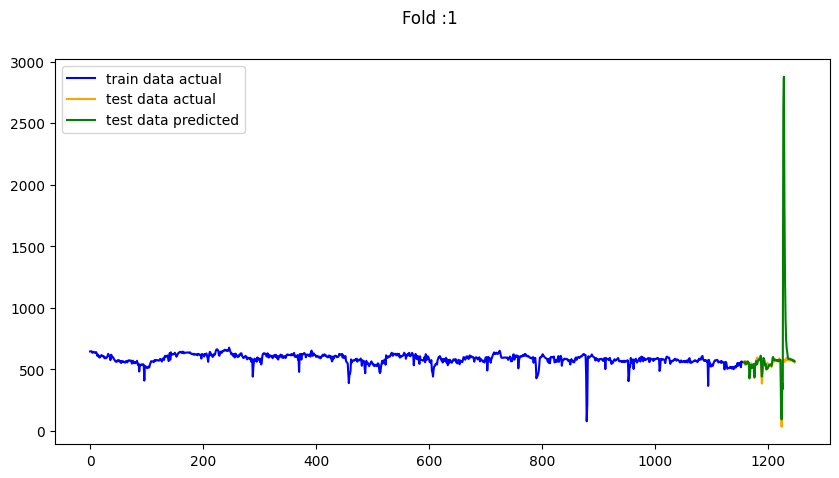

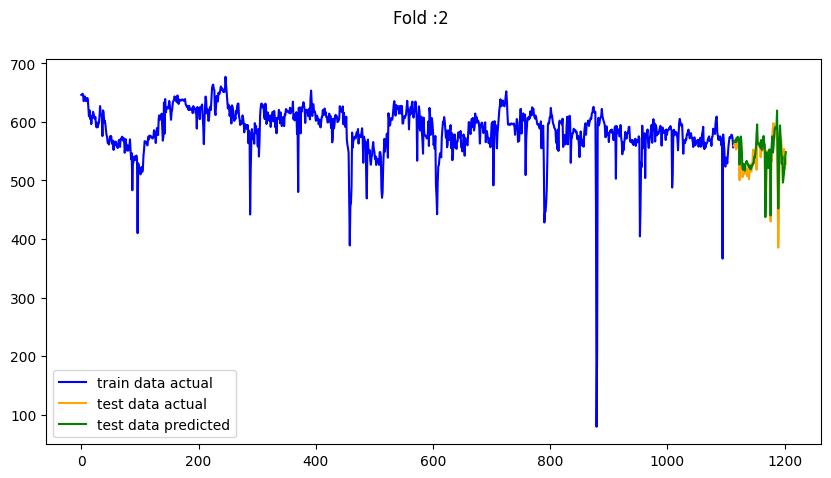

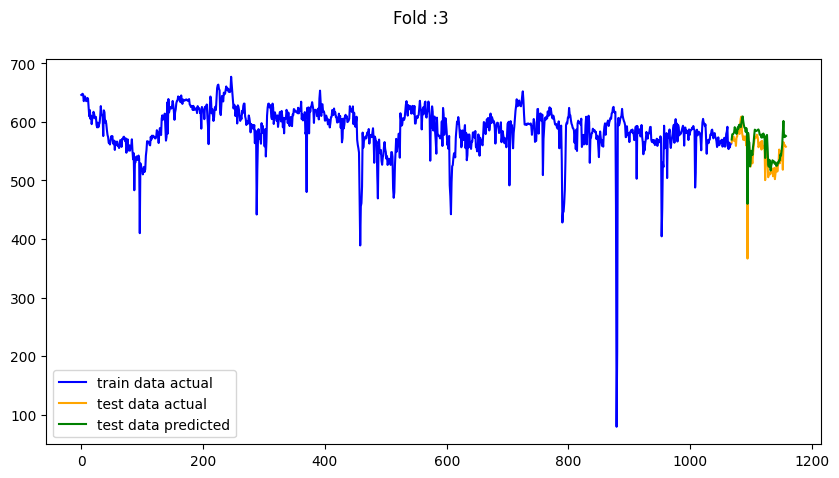

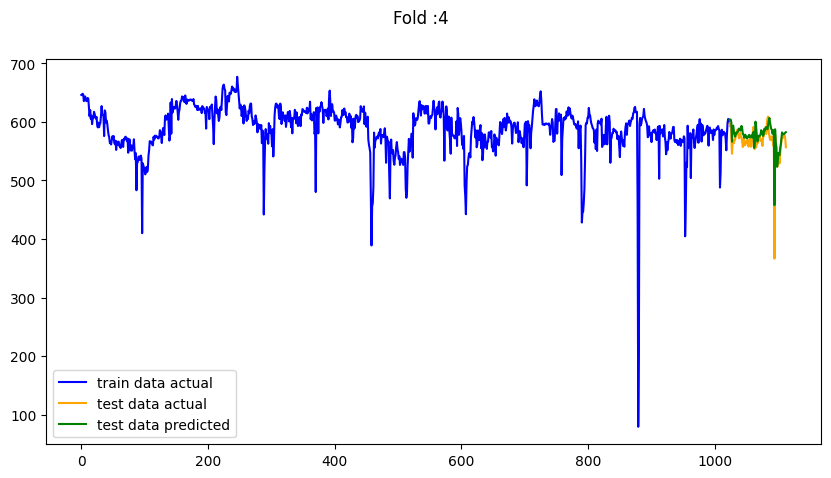

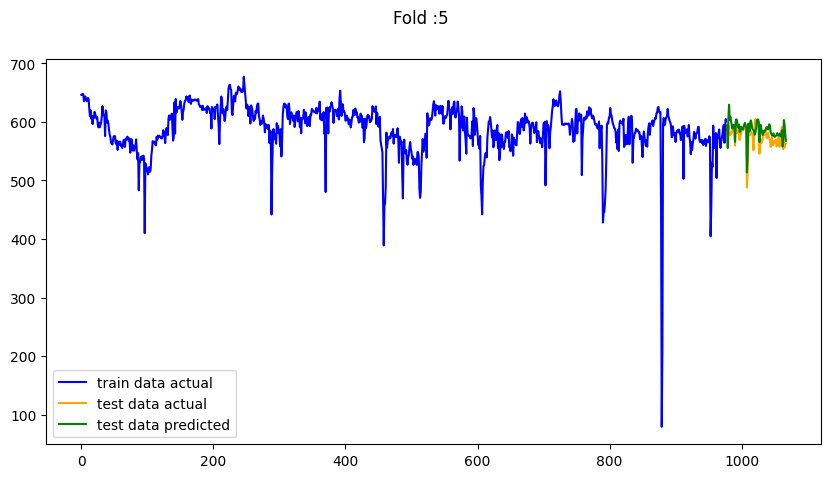

[0.19030453106924564, 0.027753907795543795, 0.029199198899157543, 0.022708760437297, 0.02323982103968537] 0.058641243848185864


In [9]:
import matplotlib.pyplot as plt

area = 13
for x in [best_param[0]]:
  for y in [best_param[1]]:
    for z in [best_param[2]]:
      df = df_raw.copy()

      #shifting

      lag_pressure = x
      #for i in range(1,14):
      for i in [area]:
        for j in range(1,lag_pressure+1):
          if i != 2:
            if i < 10:
              df['P1_SPM_A0'+str(i)+'_'+str(j)] = df['P1_SPM_A0'+str(i)].shift(j)
            else:
              df['P1_SPM_A'+str(i)+'_'+str(j)] = df['P1_SPM_A'+str(i)].shift(j)

      lag_choke = y
      for i in range(1,14):
        for j in range(1,lag_choke+1):
          if i != 2:
            if i < 10:
              df['CHOKE_AREA_A0'+str(i)+'_'+str(j)] = df['CHOKE_AREA_A0'+str(i)].shift(j)
            else:
              df['CHOKE_AREA_A'+str(i)+'_'+str(j)] = df['CHOKE_AREA_A'+str(i)].shift(j)

      lag_steam = z
      for j in range(1,lag_steam+1):
        df['COGEN'+"_"+str(j)] = df['COGEN'].shift(j)
        df['SS6'+"_"+str(j)] = df['SS6'].shift(j)
        df['SS1'+"_"+str(j)] = df['SS1'].shift(j)
        df['WHRU'+"_"+str(j)] = df['WHRU'].shift(j)
        df['TOTAL'+"_"+str(j)] = df['TOTAL'].shift(j)

      df = df.dropna()

      print (x, y, z)
      #for ii in df.columns:
      #  print (ii)


      x_cols = list(df.columns)
      for i in range(1,14):
        if (i!=area) & (i != 2):
          if i < 10:
            x_cols.remove('P1_SPM_A0'+str(i))
          else:
            x_cols.remove('P1_SPM_A'+str(i))

      if area < 10:
        x_cols.remove('P1_SPM_A0'+str(area))
        y_cols = ['P1_SPM_A0'+str(area), 'DATE']
      else:
        x_cols.remove('P1_SPM_A'+str(area))
        y_cols = ['P1_SPM_A'+str(area), 'DATE']

      #print(x_cols)
      #print(y_cols)

      twend   = [  0,  -45,  -90,  -135,  -180]
      twstart = [-90, -135, -180,  -225,  -270]

      
      error_kfold = []
      score_cv = []
      ff = 1
      for t in range(len(twstart)):
        X = df[x_cols]
        Y = df[y_cols]

        if t == 0:
          x_test = X.iloc[twstart[t]:]
          x_train = X.iloc[:twstart[t]]
          y_test = Y.iloc[twstart[t]:]
          y_train = Y.iloc[:twstart[t]]
        else:
          x_test = X.iloc[twstart[t]:twend[t]]
          x_train = X.iloc[:twstart[t]]
          y_test = Y.iloc[twstart[t]:twend[t]]
          y_train = Y.iloc[:twstart[t]]

        #print(x_test['DATE'].min(),x_test['DATE'].max(),x_train['DATE'].min(),x_train['DATE'].max(), len(x_test), len(x_train))

        x_cols_f = x_cols.copy()
        x_cols_f.remove('DATE')

        y_cols_f = y_cols.copy()
        y_cols_f.remove('DATE')
        
        x_train = x_train[x_cols_f]
        y_train = y_train[y_cols_f]

        MLP = MLPRegressor(random_state=1,solver='lbfgs',activation='relu',max_iter=10000)
        MLP.fit(x_train,y_train)

        x_test = x_test[x_cols_f].reset_index(drop=True)
        y_test = y_test[y_cols_f].reset_index(drop=True)
         
        days_to_predict = 2
        y_test_arr = []
        y_test_pred_arr = []
        y_test_pred_arr_1 = []
        #for l in range(5):
        for l in range(len(x_test)):
          #print (l)
          for p in range(1,days_to_predict+1):
            if p==1:
              x_test_l = x_test.iloc[l:l+1]
              y_test_l = y_test.iloc[l:l+1]
              #print (x_test_l.values,y_test_l.values)
              #print("INPUT :", x_test_l.loc[l])
              
              y_pred = MLP.predict(x_test_l.values.reshape(1,-1))
              #print (y_pred)
              
              y_test_l = y_test_l.values[0]
              y_pred = y_pred[0]
              #print ("OUTPUT ACTUAL VS PRED:", y_test_l, y_pred)

              pred_h1 = y_pred

              y_test_arr.append(y_test_l)
              y_test_pred_arr.append(y_pred)
              y_test_pred_arr_1.append(y_pred)
              #print(mean_absolute_percentage_error([y_test_l],[y_pred]))
            else:
              try:
                x_test_l = x_test.iloc[l+1:l+2]
                x_test_l.loc[l+1,'P1_SPM_A13_1'] = pred_h1
                y_test_l = y_test.iloc[l+1:l+2]
                #print (x_test_l.values,y_test_l.values)
                #print("INPUT :", x_test_l.loc[l+1])
                y_pred = MLP.predict(x_test_l.values.reshape(1,-1))
                #print (y_pred)
                
                y_test_l = y_test_l.values[0]
                y_pred = y_pred[0]
                #print ("OUTPUT ACTUAL VS PRED:", y_test_l, y_pred)

                y_test_arr.append(y_test_l)
                y_test_pred_arr.append(y_pred)
                #print(mean_absolute_percentage_error([y_test_l],[y_pred]))
              except:
                pass

        plt.figure(figsize=(10,5))
        plt.suptitle('Fold :' + str(ff))
        train_index = np.arange(len(x_train))
        test_index = np.arange(len(x_train),len(x_test)+len(x_train))
        #print (train_index, test_index)
        plt.plot(train_index,y_train,color='blue',label='train data actual')
        plt.plot(test_index,y_test,color='orange',label='test data actual')
        plt.plot(test_index,y_test_pred_arr_1,color='green',label='test data predicted')
        plt.legend()
        plt.show()
              
        score = mean_absolute_percentage_error(y_test_arr,y_test_pred_arr)
        score_cv.append(score)

        error_kfold.append([ff,twstart[t],len(y_train),score])

        ff=ff+1
      
      
      score_cv_mean = np.mean(score_cv)

      print (score_cv, score_cv_mean)
      #if score_cv_mean < best_score:
      #  best_score = score_cv_mean
      #  best_param = [x,y,z]    
     
      #break
    #break
 # break

In [10]:
error_kfold = pd.DataFrame(np.array(error_kfold), columns=['Fold','Test_Data_Start_Time','Train_Data_Rows','MAPE'])
error_kfold

,Fold,Test_Data_Start_Time,Train_Data_Rows,MAPE
0,1.0,-90.0,1158.0,0.190305
1,2.0,-135.0,1113.0,0.027754
2,3.0,-180.0,1068.0,0.029199
3,4.0,-225.0,1023.0,0.022709
4,5.0,-270.0,978.0,0.023240
